# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
df['Genre']

0        technical thrash metal|math metal|progressive ...
1                            grindcore|melodic death metal
2                                    symphonic power metal
3                               heavy metal|us power metal
4                                              power metal
                               ...                        
93429                                         thrash metal
93430                                          death metal
93431                                         thrash metal
93432                                            hard rock
93433                                            hard rock
Name: Genre, Length: 93434, dtype: object

In [5]:
G = nx.Graph()
B = nx.Graph()

In [6]:
genres = open('genres.txt').read().split('\n')[:-1] #nodes, lastline is newspace
len(genres)

297

In [7]:
#construction of bipartite graph
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    for genre in genre_list:
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
        else:
            B.add_edge(user, genre, weight = 1)

In [8]:
B.number_of_nodes()

8344

In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        w = B[genre1][user]['weight']
        for genre2 in B.adj[user]:
            #the weight of the edge is determined as the minimum weights of the two edges in bipartite graph
            #weights are double counted
            if genre2 >= genre1:
                continue
            w = min(w,B[genre2][user]['weight'])
            if G.has_edge(genre1,genre2):
                #G[genre1][genre2]['weight'] += w
                G[genre1][genre2]['weight'] += 1
            else:
                #G.add_edge(genre1, genre2, weight = w)
                G.add_edge(genre1, genre2, weight = 1)

In [10]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [11]:
G = calc_sim(G)

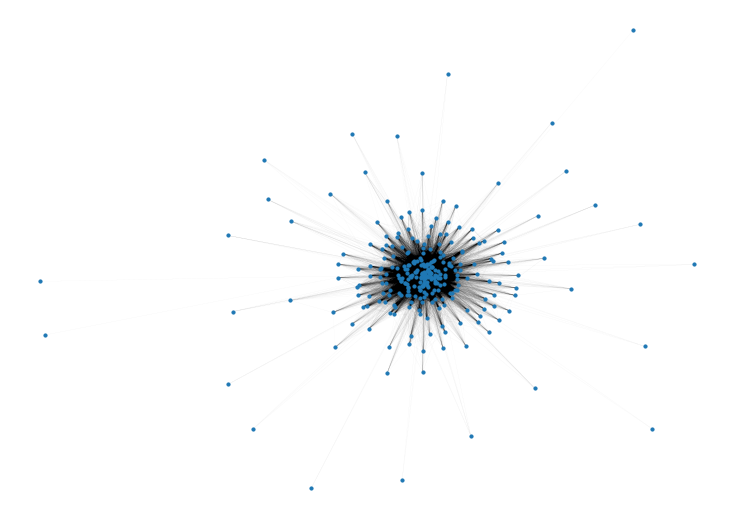

In [12]:
weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))/100
nx.draw(G, node_size = 10, width = list(weights))

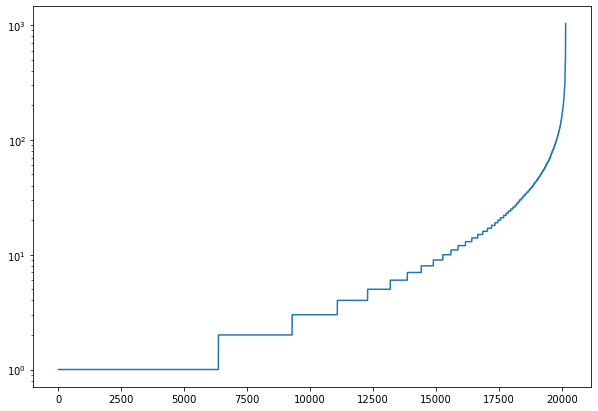

In [13]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))

In [14]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

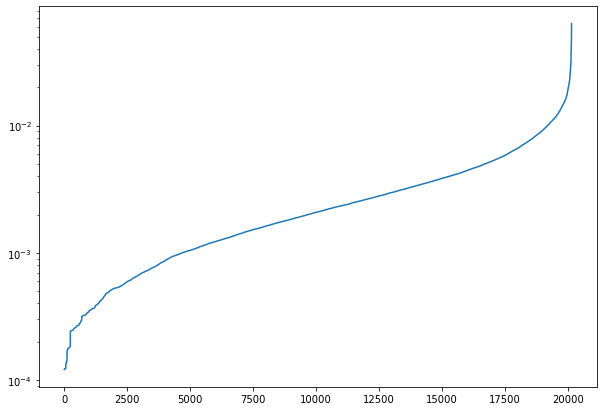

In [15]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'similarity').values())))
plt.show()

In [16]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [17]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group or genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

288
187


In [18]:
G3 = G.copy()

In [19]:
G = G3.copy()
G2 = G.copy()
print(list(nx.isolates(G)))

'''for u,v in G2.edges():
    if G2[u][v]['weight'] < 10:
        G.remove_edge(u,v)
        
G.remove_nodes_from(list(nx.isolates(G)))

G2 = G.copy()
'''
for u,v in G2.edges():
    if G2[u][v]['weight'] < 5: #10 for double counting
        G.remove_edge(u,v)
        
nx.number_connected_components(G)
print(clt.Counter([len(cc) for cc in nx.connected_components(G)]))
print(list(nx.isolates(G)))
G.number_of_nodes()

[]
Counter({1: 42, 145: 1})
['ambient folk', 'electronic symphonic metal', 'neo-classical power heavy metal', 'epic folk', 'blackened stoner metal', 'neoclassical progressive metal', 'celtic black metal', 'gothic death metal', 'nu thrash metal', 'experimental grindcore', 'acoustic folk', 'experimental progressive metal', 'electronic industrial metal', 'epic black metal', 'atmospheric progressive metal', 'medieval folk metal', 'stoner doom metal', 'celtic doom metal', 'gothic folk metal', 'blackened industrial metal', 'contemporary folk', 'experimental thrash metal', 'avantgarde doom metal', 'crossover folk metal', 'experimental doom metal', 'celtic death metal', 'groove heavy metal', 'blackened grindcore', 'blackened gothic metal', 'acoustic folk metal', 'psychedelic sludge metal', 'experimental avantgarde metal', 'groove death metal', 'medieval folk rock', 'experimental folk metal', 'death thrash metal', 'avantgarde industrial metal', 'industrial gothic metal', 'pagan death metal', 's

187

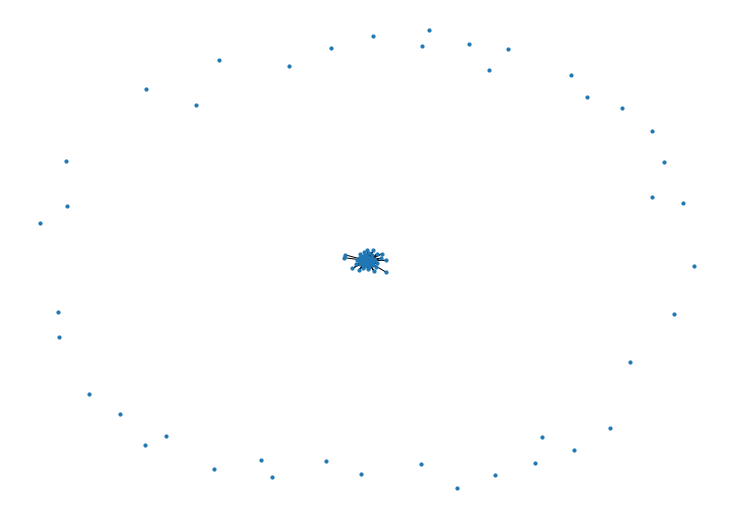

In [38]:
nx.draw(G, node_size = 10)

In [20]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [21]:
'''tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]
mp = {}
for genre in tmp:
    for item in genre[1:]:
        mp[item] = genre[0]
pickle.dump(mp,open('genre_group.p','wb'))
f = open('genres.txt').read().split('\n')[:-1]
for item in f:
    if item not in genre_group:
        print(item)'''

"tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]\nmp = {}\nfor genre in tmp:\n    for item in genre[1:]:\n        mp[item] = genre[0]\npickle.dump(mp,open('genre_group.p','wb'))\nf = open('genres.txt').read().split('\n')[:-1]\nfor item in f:\n    if item not in genre_group:\n        print(item)"

In [22]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight'):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = 0.8) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [23]:
H = G.copy()
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

43 10440 4785
1 10440 2048
1 10440 2048
7 1984 1273
7 1984 1273
9 1240 1240


In [24]:
partitions = [cc for cc in nx.connected_components(H)]

In [25]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [G.subgraph(comp) for comp in comps]
    total = [sum([G[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    #total = [sum([G[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    return total
getScore(H)

[37.60416666666668,
 85.5,
 23.085714285714275,
 21.50442477876107,
 15.842105263157885,
 48.243902439024396,
 35.85185185185185,
 44.43333333333334,
 33.53684210526317]

In [26]:
[len(cc) for cc in partitions]

[14, 16, 9, 23, 24, 23, 9, 11, 16]

In [27]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
genData(H,1)

,Genres,Sizes,Average_Weight
0,"{deathcore, progressive sludge metal, brutal d...",14,37.604167
1,"{avantgarde death metal, progressive gothic me...",16,85.500000
2,"{blackened doom metal, death doom metal, atmos...",9,23.085714
3,"{atmospheric sludge metal, industrial black me...",23,21.504425
4,"{progressive math metal, new wave of british h...",24,15.842105
5,"{oriental folk metal, melodic heavy metal, pro...",23,48.243902
6,"{extreme power metal, extreme industrial metal...",9,35.851852
7,"{stoner rock, drone doom metal, blackened slud...",11,44.433333
8,"{gothic rock, melodic black metal, gothic meta...",16,33.536842


In [28]:
G1 = G.subgraph(list(nx.connected_components(H))[1])
while not no_crossedges(G1):
    G1 = freq_network_parr(G1, 100, 4)

1 120 32
1 91 82
1 91 82
5 7 7


In [29]:
tmp1 = list(nx.connected_components(G1))
[len(cc) for cc in tmp1]

[3, 2, 2, 2, 2]

In [30]:
print(getScore(G1))

[852.6666666666667, 0, 0, 0, 0]


In [31]:
genData(G1,'2-1')

,Genres,Sizes,Average_Weight
0,"{black metal, thrash metal, death metal}",3,852.666667
1,"{progressive grindcore, blackened speed metal}",2,0.000000
2,"{post-black metal, progressive folk metal}",2,0.000000
3,"{technical metalcore, technical black metal}",2,0.000000
4,"{symphonic deathcore, black doom metal}",2,0.000000


In [32]:
G1 = G.subgraph(list(nx.connected_components(H))[2])
while not no_crossedges(G1):
    G1 = freq_network_parr(G1, 100, 4)

1 36 35
3 9 9


In [33]:
getScore(G1)

[14.0, 18.0, 72.0]

In [34]:
genData(G1,'2-2')

,Genres,Sizes,Average_Weight
0,"{atmospheric gothic metal, atmospheric doom me...",3,14.0
1,"{extreme progressive metal, epic doom metal, m...",3,18.0
2,"{gothic doom metal, folk doom metal, death doo...",3,72.0
